In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# %% [markdown]
"""
# Projet Classification Multimodale - Kaggle
**Données** : 
- Semelles (50 capteurs) 
- MoCap (129 points) 
→ 13 classes d'actions
"""
# %%
# ====================
# 1. INITIALISATION
# ====================
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

INPUT_DIR = "/kaggle/input/imtne-fisa-2-ti-multimodal-action-recognition"

/kaggle/input/imtne-fisa-2-ti-multimodal-action-recognition/test_insoles.h5
/kaggle/input/imtne-fisa-2-ti-multimodal-action-recognition/train_mocap.h5
/kaggle/input/imtne-fisa-2-ti-multimodal-action-recognition/train_labels.h5
/kaggle/input/imtne-fisa-2-ti-multimodal-action-recognition/train_insoles.h5
/kaggle/input/imtne-fisa-2-ti-multimodal-action-recognition/test_mocap.h5
Device utilisé : cpu


In [12]:
def inspect_h5_file(filename):
    with h5py.File(os.path.join(INPUT_DIR, filename), 'r') as f:
        print(f"Contenu de {filename} : {list(f.keys())}")

# Inspection de chaque fichier
inspect_h5_file("train_insoles.h5")
inspect_h5_file("train_mocap.h5")
inspect_h5_file("train_labels.h5")


Contenu de train_insoles.h5 : ['my_data']
Contenu de train_mocap.h5 : ['my_data']
Contenu de train_labels.h5 : ['my_data']


In [7]:
def load_h5_data(filename):
    with h5py.File(os.path.join(INPUT_DIR, filename), 'r') as f:
        return f['my_data'][:]

# Chargement des jeux de données
train_insoles = load_h5_data("train_insoles.h5")   # (6938, 100, 50)
train_mocap = load_h5_data("train_mocap.h5")       # (6938, 100, 129)
train_labels = load_h5_data("train_labels.h5")     # (6938, 1)

test_insoles = load_h5_data("test_insoles.h5")     # (1845, 100, 50)
test_mocap = load_h5_data("test_mocap.h5")         # (1845, 100, 129)

# Vérification des formes
print("Train insoles shape :", train_insoles.shape)
print("Train mocap shape   :", train_mocap.shape)
print("Train labels shape  :", train_labels.shape)
print("Test insoles shape  :", test_insoles.shape)
print("Test mocap shape    :", test_mocap.shape)


Train insoles shape : (6938, 5000)
Train mocap shape   : (6938, 12900)
Train labels shape  : (6938, 1)
Test insoles shape  : (273, 5000)
Test mocap shape    : (273, 12900)



Après reshape :
Train insoles : (6938, 100, 50)
Train mocap   : (6938, 100, 129)
Test insoles  : (273, 100, 50)
Test mocap    : (273, 100, 129)


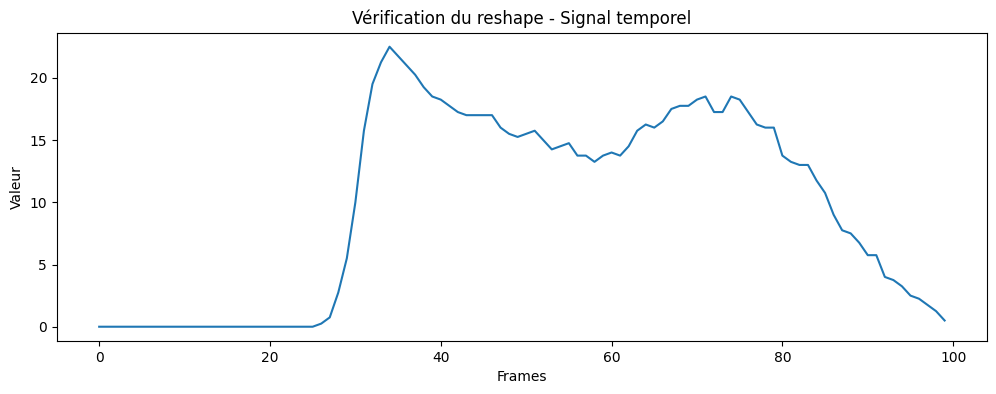

In [13]:
# Correction des shapes
def reshape_data(data, time_steps, features):
    """Reconstruit la structure temporelle"""
    return data.reshape(-1, time_steps, features)

# Reshape des données d'entraînement
train_insoles = reshape_data(train_insoles, time_steps=100, features=50)
train_mocap = reshape_data(train_mocap, time_steps=100, features=129)

# Reshape des données de test
test_insoles = reshape_data(test_insoles, time_steps=100, features=50)
test_mocap = reshape_data(test_mocap, time_steps=100, features=129)

# Vérification
print("\nAprès reshape :")
print("Train insoles :", train_insoles.shape)  # Doit être (6938, 100, 50)
print("Train mocap   :", train_mocap.shape)    # Doit être (6938, 100, 129)
print("Test insoles  :", test_insoles.shape)   # Doit être (273, 100, 50)
print("Test mocap    :", test_mocap.shape)     # Doit être (273, 100, 129)

# Vérification visuelle
plt.figure(figsize=(12, 4))
plt.plot(train_insoles[0, :, 0])  # Premier échantillon, premier capteur
plt.title("Vérification du reshape - Signal temporel")
plt.xlabel("Frames")
plt.ylabel("Valeur")
plt.show()


In [9]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Extraction des labels (on suppose qu'ils sont dans train_labels['my_data'])
labels_raw = train_labels.squeeze()  # (6938,) au lieu de (6938, 1)

# Encodage des labels si ce sont des strings ou catégories
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_raw)

# Affichage
print("Labels encodés :", np.unique(labels_encoded))
print("Nombre de classes :", len(np.unique(labels_encoded)))
print("Shape des labels :", labels_encoded.shape)


Labels encodés : [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Nombre de classes : 13
Shape des labels : (6938,)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Classe Dataset
class MultimodalDataset(Dataset):
    def __init__(self, insoles, mocap, labels=None):
        self.insoles = torch.tensor(insoles, dtype=torch.float32)
        self.mocap = torch.tensor(mocap, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.insoles)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.insoles[idx], self.mocap[idx], self.labels[idx]
        else:
            return self.insoles[idx], self.mocap[idx]

# Création des datasets
train_dataset = MultimodalDataset(train_insoles, train_mocap, labels_encoded)
test_dataset = MultimodalDataset(test_insoles, test_mocap)

# Split en train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train batchs : {len(train_loader)} | Val batchs : {len(val_loader)} | Test batchs : {len(test_loader)}")


Train batchs : 87 | Val batchs : 22 | Test batchs : 5


In [ ]:
# %% [markdown]
"""
## Architecture Modèle avec Fusion Multimodale
**Spécifications** :
- Branche semelles (50 → 64 → 128)
- Branche mocap (129 → 128 → 256)
- Fusion par attention
- Classifieur final
"""
# %%
class MultimodalActionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Branche Semelles (CNN 1D + LSTM)
        self.insoles_conv = nn.Sequential(
            nn.Conv1d(50, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 100 → 50
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.insoles_lstm = nn.LSTM(128, 64, batch_first=True)
        
        # Branche MoCap (CNN 1D + LSTM)
        self.mocap_conv = nn.Sequential(
            nn.Conv1d(129, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 100 → 50
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.mocap_lstm = nn.LSTM(256, 128, batch_first=True)
        
        # Mécanisme d'Attention
        self.attention = nn.Sequential(
            nn.Linear(64 + 128, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        
        # Classifieur
        self.classifier = nn.Sequential(
            nn.Linear(64 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 13)
    
    def forward(self, x_insoles, x_mocap):
        # Semelles [batch, 100, 50] → [batch, 64]
        x1 = x_insoles.permute(0, 2, 1)  # → [batch, 50, 100]
        x1 = self.insoles_conv(x1)       # → [batch, 128, 50]
        x1 = x1.permute(0, 2, 1)         # → [batch, 50, 128]
        x1, _ = self.insoles_lstm(x1)    # → [batch, 50, 64]
        x1 = x1.mean(dim=1)              # → [batch, 64]
        
        # MoCap [batch, 100, 129] → [batch, 128]
        x2 = x_mocap.permute(0, 2, 1)    # → [batch, 129, 100]
        x2 = self.mocap_conv(x2)         # → [batch, 256, 50]
        x2 = x2.permute(0, 2, 1)         # → [batch, 50, 256]
        x2, _ = self.mocap_lstm(x2)      # → [batch, 50, 128]
        x2 = x2.mean(dim=1)              # → [batch, 128]
        
        # Fusion avec attention
        combined = torch.stack([x1, x2], dim=1)  # → [batch, 2, 192]
        weights = self.attention(torch.cat([x1, x2], dim=1))  # → [batch, 2]
        weighted = (combined * weights.unsqueeze(2)).sum(dim=1)  # → [batch, 192]
        
        return self.classifier(weighted)  # → [batch, 13]

# %%
# Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalActionModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# %%
# Boucle d'entraînement
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for insoles, mocap, labels in tqdm(loader, desc="Training"):
        insoles, mocap, labels = insoles.to(device), mocap.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(insoles, mocap)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for insoles, mocap, labels in loader:
            insoles, mocap, labels = insoles.to(device), mocap.to(device), labels.to(device)
            
            outputs = model(insoles, mocap)
            total_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(loader), correct / len(loader.dataset)

# %%
# Entraînement complet
best_val_acc = 0
for epoch in range(30):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    
    print(f"\nEpoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Nouveau meilleur modèle sauvegardé !")

# %%
# Chargement du meilleur modèle
model.load_state_dict(torch.load("best_model.pth"))

# Évaluation finale
val_loss, val_acc = eval_epoch(model, val_loader, device)
print(f"\nPerformance finale sur le validation set:")
print(f"Accuracy: {val_acc:.2%} | Loss: {val_loss:.4f}")